# Stein method with metric induced by collective variables

For dimer - radius

In [1]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler 
import model 

import numpy as np
from simtk import openmm, unit

from pydiffmap import diffusion_map as dmpy
import helpers
import model

In [2]:
# qid = np.load('../Data_Tests/Alanine/stein.npy')
# print(qid)

In [3]:
diffmapmethod='T500/'
methodName='std_500/'
methodNameFolder=diffmapmethod+methodName

#######################
# target temperature
T=300.0


metric_choice = 'euclidean'
  
dataName='Results/'
folderName='/Users/zofia/github/DFM/'
modelName='Dimer'

dataFolderName = folderName+dataName+modelName+'/'+methodNameFolder

# results from this code will be saved here:
simulationFolder=dataFolderName+'/Figures'

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

print(dataFolderName)

mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())

temperature =  T * unit.kelvin#300 * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')



/Users/zofia/github/DFM/Results/Dimer/T500/std_500/
Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=3.55, unit=angstrom)
0
angstrom
System has 2 particle(s)
440.662128047 K


# Load trajectory here

Loaded trajectory of length 10000


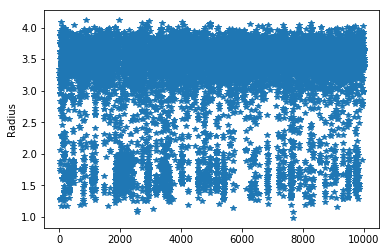

In [4]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = False

modnr=10
X_FT = helpers.loadData(dataFolderName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))

#compute collective variable
collective_variable = helpers.compute_radius

cv_name='Radius'
r=collective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r, '*')
plt.ylabel(cv_name)
#plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [5]:
def plotSampling_fromData(X_FT, smpl, methodName=None, color=None, title=None, leader_set=None):
    
    E = helpers.computeEnergy(X_FT, smpl)
    radius = helpers.compute_radius(X_FT)
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    
    ax.scatter(radius, E, s=2, c=E);
    ax.set_title(title)
    ax.set_xlabel('Radius')
    
    ax.set_ylabel('Energy')
    
    plt.show()



In [6]:
import dimension_reduction
X_FT =dimension_reduction.align_with_mdanalysis(X_FT, smpl)

/Users/zofia/miniconda3/lib/python3.6/site-packages/MDAnalysis/__init__.py:245: UserWarning: #####
MDAnalysis on python 3 is highly experimental!
It is mostly non functional and dramatically untested.
Use at your own risks!!!

  ''')


In [7]:
def compute_free_energy(cv, weights=None, nrbins=100):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)

    return free_energy, bin_centers

#  Stein force

In [8]:
def radius_state(X):
    n = int(X.shape[0]/3)
    X =X.reshape(n, 3)
    return np.linalg.norm(X[0,:]-X[1,:], 2)


def compute_grad_radius(X):
    dx = X[0,:]-X[1,:]
    
    r = np.linalg.norm(dx,2)
    mtr = np.zeros(dx.shape)
    mtr[:,0] = dx[:,0]/r
    mtr[:,1] = dx[:,1]/r
    mtr[:,2] = dx[:,2]/r

    return mtr

def cv_metric(X, Y):
    
    return np.abs(radius_state(X) - radius_state(Y))
    

In [9]:
def compute_radius(X):
    return np.linalg.norm(X[0,:]-X[1,:], 2)

def compute_grad_radius(X):
    dx = np.zeros(X.shape)
    dx[0,:] = X[0,:]-X[1,:]
    dx[1,:] =   -  dx[0,:]
    
    r = np.linalg.norm(dx)
    #print(dx.shape)
    mtr = np.zeros(dx.shape)
    mtr[:,0] = dx[:,0]/r
    mtr[:,1] = dx[:,1]/r
    mtr[:,2] = dx[:,2]/r

    return mtr

collective_variable = compute_radius
grad_collective_variable = compute_grad_radius

In [10]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    force = []
    
    for n in range(len(leader_set)):
        force.append( smpl.model.force(XL[leader_set[n]]))

    return force

def compute_force_all(XL):
       
    force = []
    
    for n in range(len(XL)):
        force.append( smpl.model.force(XL[n]))

    return force

def compute_stein_force(XL, leader_set, model, cv = False, cv_params = {'grad_collective_variable':None, 'collective_variable':None, 'dim_cv':1}):
   
    force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    forcenp = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(leader_set)):
        forcenp.append(force[n].value_in_unit(smpl.model.force_unit))
    
    forcenp = np.asarray(forcenp)
    # create numpy array from the list XL which has also units
    
    
    
    XreshList = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(XL)):
        XreshList.append(XL[n].value_in_unit(model.x_unit))
    
    
    
    if cv is True:
        # project X on theta(X) directly
        Xresh = np.zeros((len(XreshList),cv_params['dim_cv']))
        
        # dXL is nabla_x theta(X)
        dXL = np.zeros(np.asarray(XreshList).shape)
        
        for n in range(len(XL)):
            dXL[n,:,:] = cv_params['grad_collective_variable'](XreshList[n])
            Xresh[n,:] = cv_params['collective_variable'](XreshList[n])
        
        # dXL has the same shape as X
        dXL = dXL.reshape(dXL.shape[0],dXL.shape[1]*dXL.shape[2])
    else:
        Xresh = np.asarray(XreshList)
    
    
        # reshape for neighbor search steps x DOF
        Xresh = Xresh.reshape(Xresh.shape[0],Xresh.shape[1]*Xresh.shape[2])
    
    # choose leader particles using the index set leader_set
    X_leader = np.copy(Xresh[leader_set,:])
    
    force_resh = forcenp.reshape(forcenp.shape[0],forcenp.shape[1]*forcenp.shape[2])
   
    # D f(psi(X))D psi(X)
    
    # kernel scaling parameter
    h=0.01
    
    #distances = cdist(X_leader, Xresh)
    distances = cdist(X_leader, Xresh, metric='euclidean')

    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    
    f_MDforce = np.dot(kernel.transpose(), force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    
    # reshape to format (N_particles, n_atoms, 3)
    f_MDforce = f_MDforce.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    
    # add force unit and divide by kT
    f_MDforce = f_MDforce * model.force_unit / smpl.kT
    
    
    
#     if cv is True:
#         kernel_theta = np.zeros(kernel.shape)
#         for i in range(len(X_leader)):
#                 for j in range(len(Xresh)):
#                     kernel_theta[i,j] = kernel[i,j]*(X_leader[i]-Xresh[j])

#         f_der = -2.0/h * np.dot(kernel_theta.transpose(), dXL)
#         f_der = f_der / len(leader_set)
        
       
#     else:    
#         # derivative part
#         f_der = -2.0/h * np.dot(kernel, X_leader)
#         f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(Xresh.shape[1])) * Xresh
#         f_der = f_der / len(leader_set)

    #     derivative part
    if cv is True:
        kernel_theta_1 = kernel * X_leader
        kernel_theta_2 = (Xresh*kernel.transpose()).transpose()
        kernel_theta = kernel_theta_1 - kernel_theta_2

        f_der = -2.0/h * np.dot(kernel_theta.transpose(), dXL)
        
    else:
        
        f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
        f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(XL.shape[1])) * XL
        
    f_der = f_der / len(leader_set)
        
    #reshape to format (N_particles, n_atoms, 3)
    f_der = f_der.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add unit
    f_der = f_der * model.x_unit**(-1)
    
    
#     #derivative part
#     f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
#     f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(Xresh.shape[1])) * Xresh
#     f_der = f_der / len(leader_set)
#     # reshape to format (N_particles, n_atoms, 3)
#     f_der = f_der.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
#     # add unit
#     f_der = f_der * model.x_unit**(-1)
    
    return f_MDforce + f_der



# Iterate Stein

In [11]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
    
def align_with_mdanalysis(X_FT, smpl):

    trj = mda.Universe(smpl.model.modelName+'.pdb', X_FT)
    ref = mda.Universe(smpl.model.modelName+'.pdb')
    # trj = mda.Universe('/Users/zofia/github/DFM/alanine.xyz', X_FT)
    # print(trj.trajectory)
    # ref = mda.Universe('/Users/zofia/github/DFM/alanine.xyz')#, X_FT[0,:,:])


    alignment = align.AlignTraj(trj, ref)#, filename='rmsfit.dcd')
    alignment.run()
    X_aligned = np.zeros(X_FT.shape)
    ci=0
    for ts in trj.trajectory:
        X_aligned[ci] = trj.trajectory.ts.positions
        ci=ci+1

    #X_aligned = (trj.trajectory.positions)
    #print(X_aligned.shape)
    #print(alignment)
    return X_aligned

def rmsd_align(XL):
    
    X_FT=[]
    for i in range( len(XL)):
        X_FT.append(XL[n].value_in_unit(smpl.model.x_unit))
    
    X_FT = np.asarray(X_FT)
    X_FT = align_with_mdanalysis(X_FT, smpl)
    
    XLnew=[]
    for i in range(len(XL)):
        XLnew.append(unit.Quantity(X_FT[n],smpl.model.x_unit))
        
    return XLnew

#XL = rmsd_align(X_FT)

In [12]:
def Langevin_step(x , v, f,a, b,  dt):
    
    v = v + ((0.5*dt ) * f/ smpl.model.masses)
    x = x + ((0.5*dt ) * v)


    v = (a * v) + b * np.random.randn(*x.shape) * np.sqrt(smpl.kT / smpl.model.masses)

    x = x + ((0.5*dt ) * v)
    f=smpl.model.force(x)

    v = v + ((0.5*dt ) * f / smpl.model.masses)
    
    return x, v , f

In [13]:
# load reference free energy profile at 300 K
reference_folder_300K='/Users/zofia/github/DFM/Results/Dimer/T300/'

FE_ref = np.load(reference_folder_300K+ 'reference_dimer_300K_radius_100bins.npy')
bc_ref = np.load(reference_folder_300K+ 'reference_dimer_300K_bins_100bins.npy')


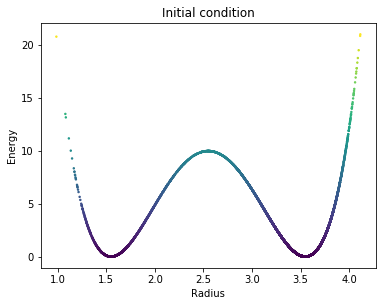

Stein iteration 0


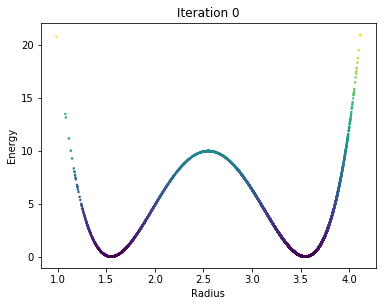

Stein iteration 10


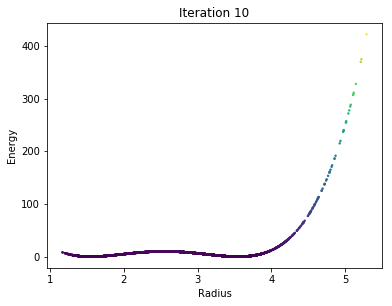

Stein iteration 20


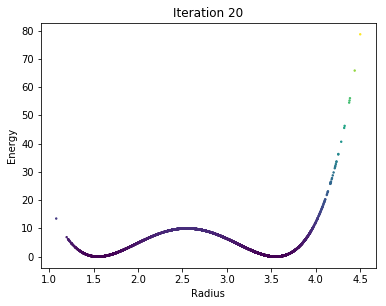

Stein iteration 30


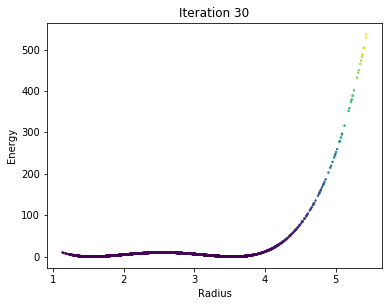

Stein iteration 40


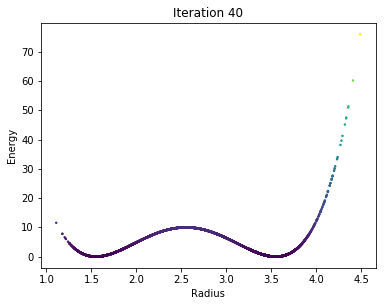

Stein iteration 50


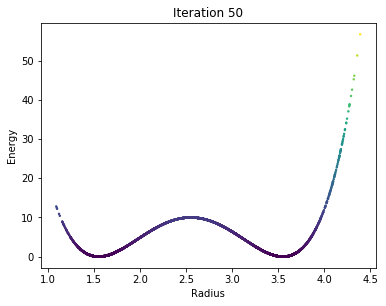

Stein iteration 60


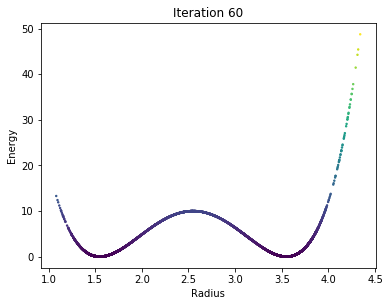

Stein iteration 70


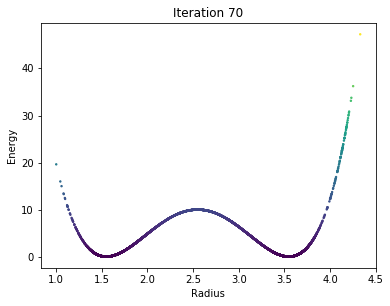

Stein iteration 80


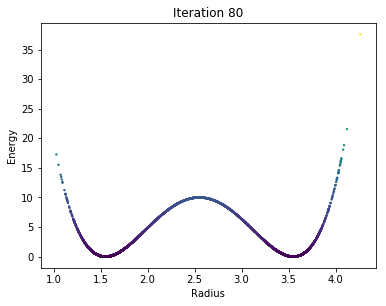

Stein iteration 90


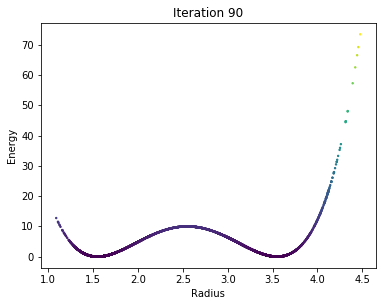

In [14]:
numberOfSteinSteps = 100

X_short = np.copy(X_FT[::1])
XL = []
[XL.append( X_short[n] * smpl.model.x_unit) for n in range(X_short.shape[0])]

epsilon_step=unit.Quantity(1.0, smpl.model.x_unit)**2

# choose leader set
numberOfLeaderParticles = int(1.0*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

kT = smpl.kT
mass = smpl.model.masses 

q = np.copy(X_short)

numberOfLangevinSteps = 1
a = np.exp(-smpl.integrator.gamma * (smpl.integrator.dt))
b = np.sqrt(1 - np.exp(-2 * smpl.integrator.gamma * (smpl.integrator.dt)))


plotSampling_fromData(q, smpl, methodName=None, color='b', title = 'Initial condition')

params = {'grad_collective_variable':grad_collective_variable,
          'collective_variable':collective_variable, 'dim_cv':1}

f = compute_stein_force(XL,leader_set, smpl.model, cv = True, cv_params = params)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/10)
free_energies=[]
bins=[]
nrBins=100

states=[]


for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
        ## plot progress
        plotSampling_fromData(q, smpl, methodName=None, color='b', title = 'Iteration '+repr(ns))
    f = compute_stein_force(XL,leader_set, smpl.model, cv = True, cv_params = params)
    for n in range(len(XL)):
        #XL = rmsd_align(XL)
        XL[n] = (XL[n] + epsilon_step * f[n])
        if numberOfLangevinSteps>0:
            fLan = smpl.model.force(XL[n])
            v = np.random.randn(*XL[n].shape) * np.sqrt(smpl.kT / smpl.model.masses)
            for i in range(numberOfLangevinSteps):
                XL[n], v, fLan = Langevin_step(XL[n] , v, fLan,a, b,  smpl.integrator.dt)
        q[n,:,:] =  np.copy(XL[n].value_in_unit(smpl.model.x_unit))
        
        #cv_stein=colective_variable(q)
        #fe, bs = compute_free_energy(cv_stein, nrbins = bc_ref)
        
        #free_energies.append(np.copy(fe))
        #bins.append(np.copy(bs))
        
        #states.append(np.copy(q))
        
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

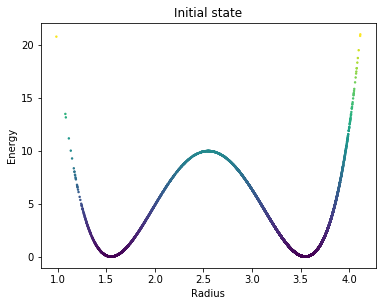

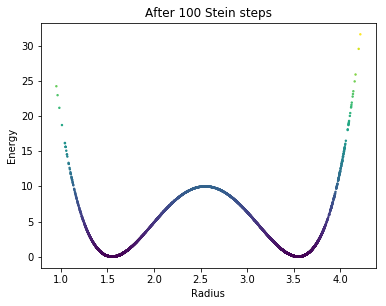

In [15]:

plotSampling_fromData(X_short, smpl, methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, smpl, methodName=None, color='b', title='After '+repr(numberOfSteinSteps)+' Stein steps')


# Compare free energies with reference

Computing collective variable of trajetory of  10000 points


/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


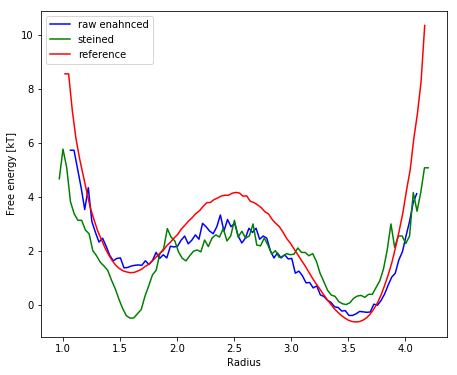

In [16]:
nrBins=100

print('Computing collective variable of trajetory of  '+repr(len(X_short))+' points')
cv=helpers.compute_radius(X_short)
cv_stein=helpers.compute_radius(q)

free_energy_raw_phi, bin_centers_raw_phi = compute_free_energy(cv, nrbins = nrBins)
free_energy_SteinIS_phi, bin_centers_SteinIS_phi = compute_free_energy(cv_stein, nrbins = nrBins)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.plot(bin_centers_raw_phi, free_energy_raw_phi,'b')# s=5, c='b', marker='o')
ax.plot(bin_centers_SteinIS_phi, free_energy_SteinIS_phi, 'g')#s=5, c='g', marker='o')
ax.plot(bc_ref, FE_ref,'r')# s=5, c='r', marker='o')
plt.legend(['raw enahnced', 'steined', 'reference'])
ax.set_xlabel('Radius')
ax.set_ylabel('Free energy [kT]')
plt.savefig('SteinFigures/Dimer/free_energy_steined_langevin.png',  format='png', dpi=100, bbox_inches='tight')
plt.show()
